In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stability(file_name):
    responses = np.load(f"test_cache/permute/{file_name}.npz")
    for key in ["finer"]:
        try:
            train_averaged = np.average(responses[key], axis = 0)
            train_std = np.std(responses[key], axis = 0)
            plt.plot(train_averaged, color = "blue")
            plt.fill_between(range(len(train_averaged)), np.clip(train_averaged - train_std, 0, 1), np.clip(train_averaged + train_std, 0, 1),
                            color='blue', alpha=0.1)
            plt.xlabel("Length")
            plt.ylabel("Performance")
            plt.title(f"File - {file_name} + {key}")
            plt.show()
        except:
            pass

In [14]:
responses = np.load(f"/home/pholur/dna2vec/evaluate/test_cache/permute/run_config-trained-all-all_random_sub_100_50_25.npz")
print("Accuracy: ", np.sum(responses["finer"][:, 800:1000])/(200*responses["finer"].shape[0]))

Accuracy:  0.9333333333333333


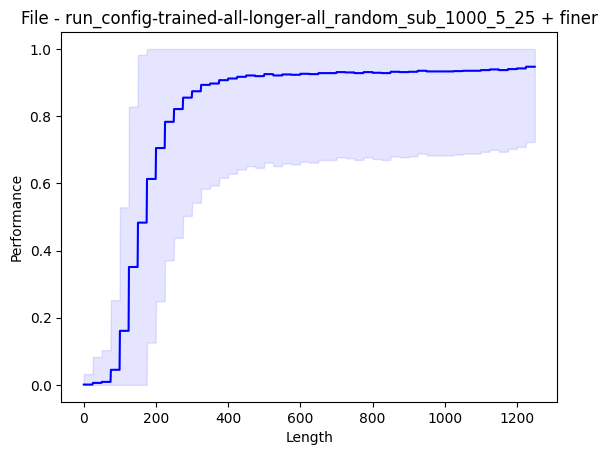

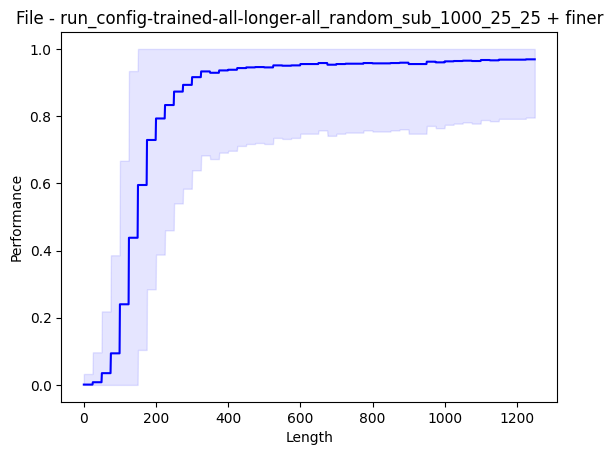

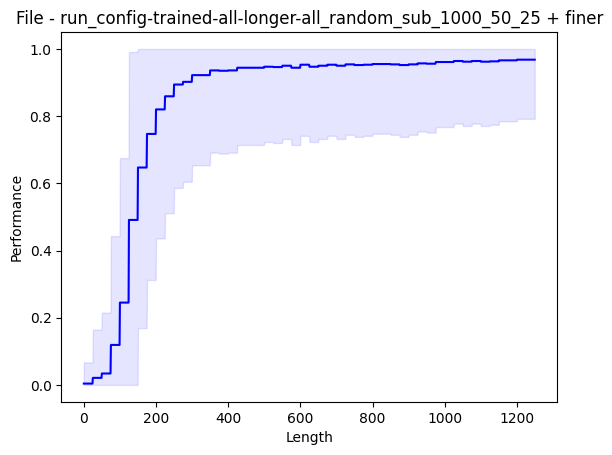

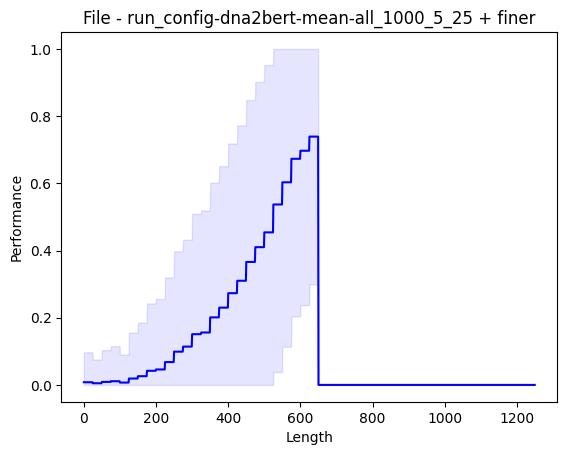

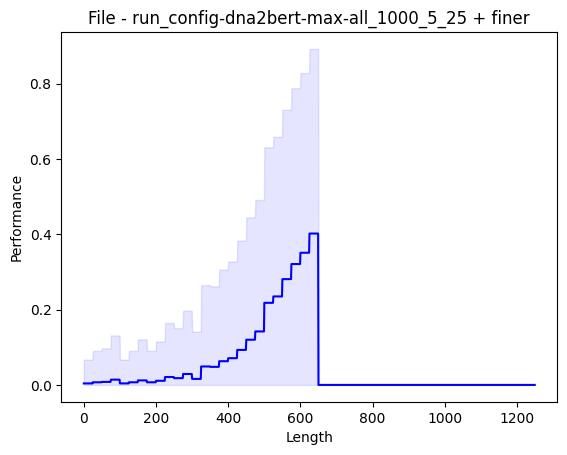

In [7]:
plot_stability("run_config-trained-all-longer-all_random_sub_1000_5_25")
plot_stability("run_config-trained-all-longer-all_random_sub_1000_25_25")
plot_stability("run_config-trained-all-longer-all_random_sub_1000_50_25")

plot_stability("run_config-dna2bert-mean-all_1000_5_25")
plot_stability("run_config-dna2bert-max-all_1000_5_25")

plot_stability("run_config-dna2bert-mean-all_1000_25_25")
plot_stability("run_config-dna2bert-max-all_1000_25_25")

plot_stability("run_config-dna2bert-mean-all_1000_50_25")
plot_stability("run_config-dna2bert-max-all_1000_50_25")
#plot_stability("run_config-dna2bert-all_random_sub_50_5_25")
#plot_stability("run_config-dna2bert-all_random_sub_50_25_25"d)